In [256]:
!pip3 install matplotlib
!pip3 install graphviz


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [257]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [258]:
class Value:

    def __init__(self, data, _children=(), _op = '', label = '', grad = 0.0):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = grad
        # applicable for leaf node
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward
        
        return out
    
    def __add__(self, other):
        # if not an instance of value, we'll assume that it is an integer and convert
        # it into a Value instance.
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __sub__(self, other):
        return self + (-other)

    def __neg__(self):
        return self * -1
    
    def __radd__(self, other): # other + self
        return self + other

    def __rmul__(self, other):
        return self * other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        self.grad = 1
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node._backward()

In [259]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this op node to the result node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

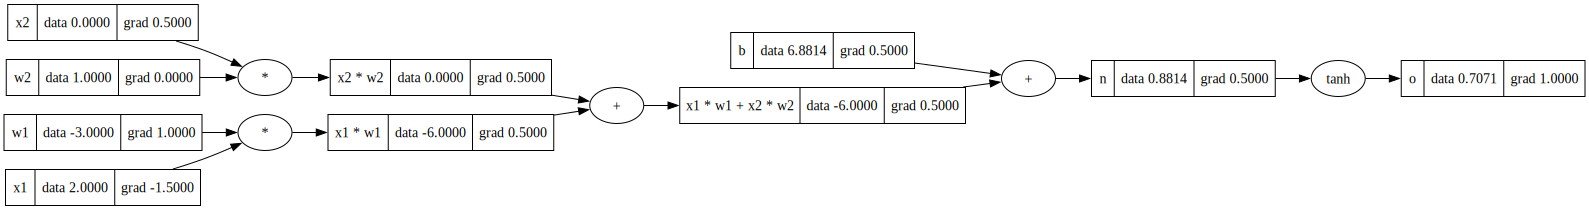

In [260]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights (synaptic strength of each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

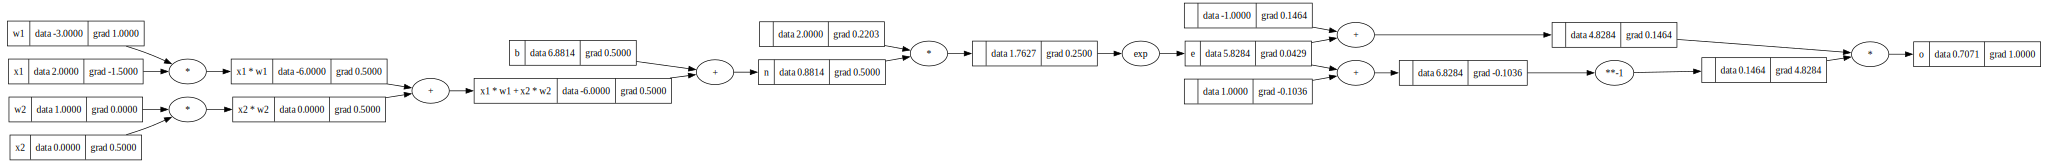

In [261]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights (synaptic strength of each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1 * w1'
x2w2 = x2 * w2; x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1 * w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)

In [262]:
a = Value(2.0)
a + 1
a * 2
2 * a # python will first try to do a * 2, if that doesn't work, it will check if a has a rmul 
# implementation (fallback)
a.exp()
b = Value(4.0)

# a / b = a * (b**-1)s
# a / b
# better to build in a generic way such that result can be derived from base expressions
a / b
a - b

Value(data=-2.0, label=)

* Amazing thing: d/dx (e^x) = e^x

In [263]:
!pip3 install torch


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [264]:
import torch

In [265]:

x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
# leaf nodes b default have requires_grad = False for optimization reasons, so we need to set it 
# explicitly.
n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("----")
print(x1, x1.grad.item())
print(x2, x2.grad.item())
print(w1, w1.grad.item())
print(w2, w2.grad.item())

0.7071066904050358
----
tensor([2.], dtype=torch.float64, requires_grad=True) -1.5000003851533106
tensor([0.], dtype=torch.float64, requires_grad=True) 0.5000001283844369
tensor([-3.], dtype=torch.float64, requires_grad=True) 1.0000002567688737
tensor([1.], dtype=torch.float64, requires_grad=True) 0.0


# Neuron, Layer and MLP Class

## Neuron Class
* This class will be responsible for business logic creating random weights and bias.
* It will take the input and then produce after applying all the weight, bias and the activation function.
* Input of neuron ==> x ==> list of inputs
* nin = len(x)
* Create list w (weights) of size nin with random weights between -1 and 1.
* Create a random bias value (b) bw -1 and 1.
* Neuron will have a single output value of sigma(wi, xi) + b

## Layer Class
* A layer is just a collection of n neurons.
* Each neuron will have their own random weights and bias.
* We just need to tell the number of output neurons of a layer.
* Implementation:
    * Input: x, number of outputs.
    * Create n neuron classes.
    * Call the neuron function for each with the same input x.

# MLP Class
* A MLP is just a collection of l layers.
* Output of ith layer is the input of (i + 1)th layer.
* Implementation:
    * Input: x and the output number of neurons of each layer.
    * Example: [4, 4, 1] ==> first layer will give 4 outputs, second layer: 4 outputs, final layer: 1 output.
    * Iteratively keeping on calling the layer function.
    * We have x which is the input of first layer.
        * Then we call the layer function. After which the output of this becomes x.

Value(data=0.5312998947403561, label=)


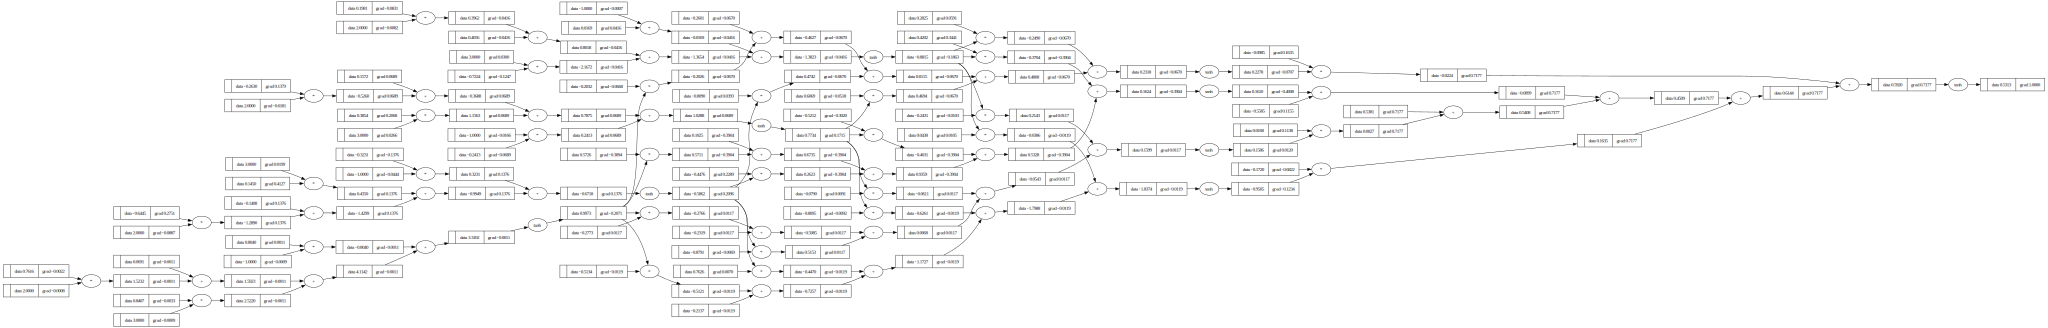

In [266]:
import random

class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    # call method is used when we want to use an instance as a function
    def __call__(self, x):
        # sigma(wi * xi) + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), start=self.b)
        return act.tanh()

    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self, nin, nout):
        # create nout output neurons
        # each neuron has nin input neurons
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        # evaluate each of the output neurons with input values, which is x.
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        # input of first layer is x
        # after that we keep changing x as the output of previous layer
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
# n = Neuron()
# n = Layer(6)
n = MLP(3, [4, 4, 1])
output = n(x)
print(output)
output.backward()
draw_dot(output)

# Creating a tiny dataset, writing the loss function

- Below xs array has 4 different inputs.
- ys array has the 4 corresponding targets.
- This is a very simple binary classifier.
- We generate ypred using the MLP that we built.
- How do we tune the weights and bias to better predict the desired target?
- Calculate a single number that measures the total performance of the neural net. This number is called "loss".
- In this example, we will calculate the mean-squared loss.
- gt here stands for ground truth.

In [267]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.5312998947403561, label=),
 Value(data=0.10540659025333485, label=),
 Value(data=0.31882995169872497, label=),
 Value(data=0.45340425454394584, label=)]

In [268]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.479682868894226, label=)

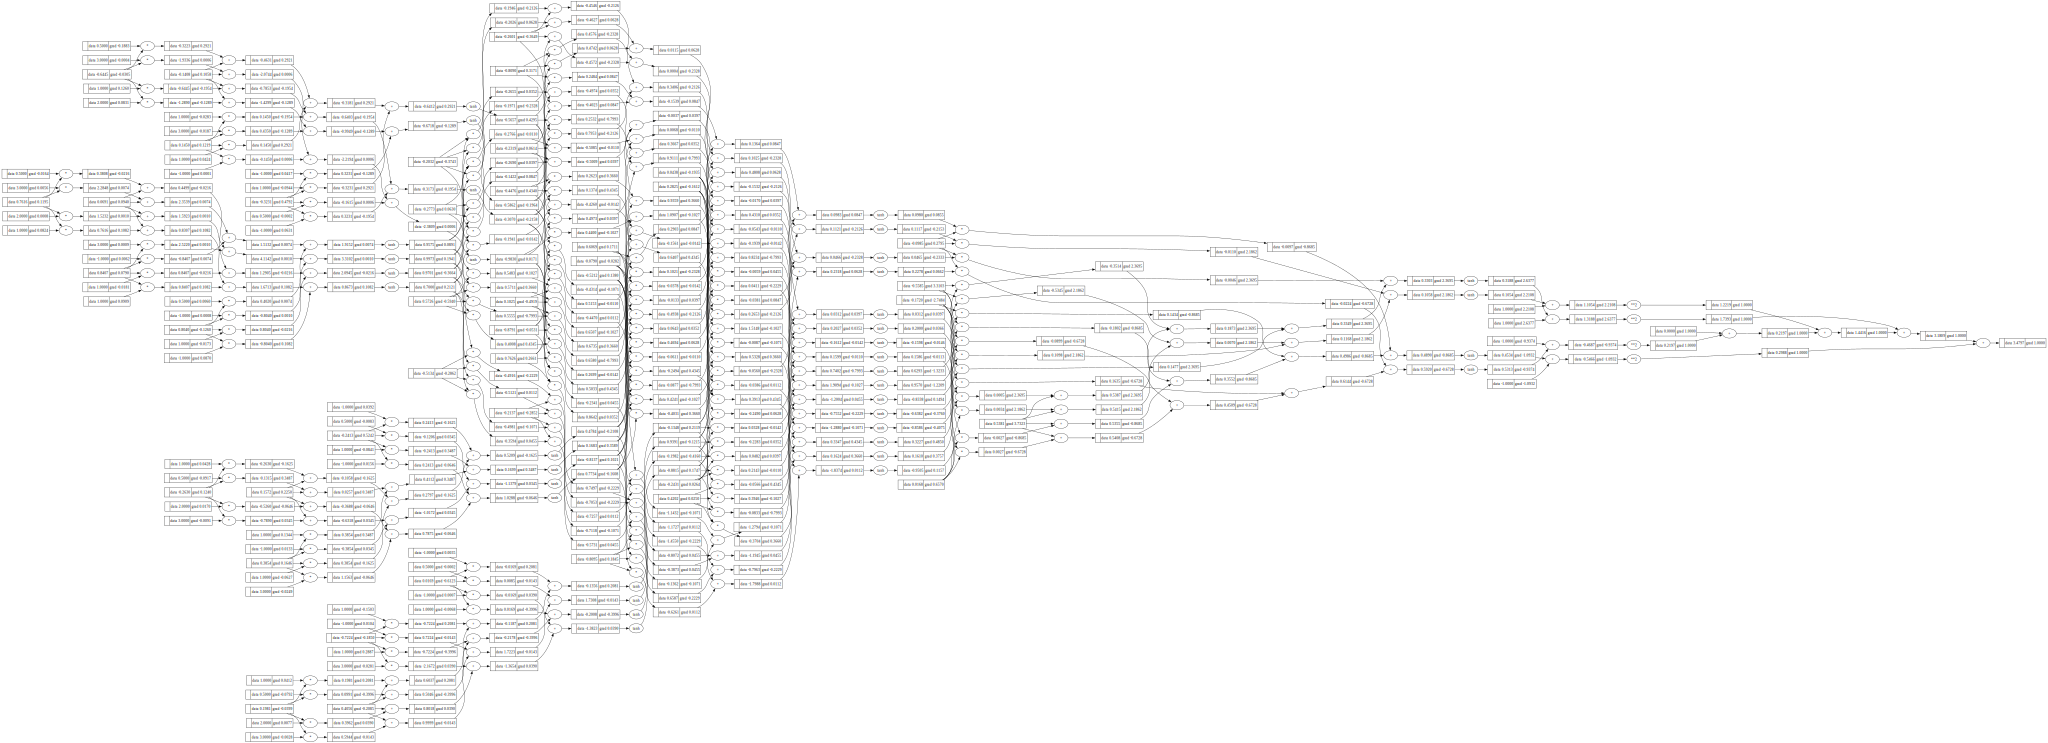

In [269]:
# how are we able to do this if loss is not of type Value?
loss.backward()
draw_dot(loss)

# Collecting all the parameters
* Create a parameters function in all 3 classes: Neuron, Layer and MLP which will give all the weights and biases.

In [270]:
len(n.parameters())

for p in n.parameters():
    print(p.grad)

0.11948989791443163
0.07901073841545697
-0.12597396139676015
0.09396350857107366
-0.030454417810852147
0.12190604133409841
0.47920203049924126
0.10583084830135789
0.12395692001505329
0.16462381770627285
0.5242056917440544
0.2249995307047908
-0.039949483293000715
-0.18501287895551385
-0.6122544004781156
-0.20848281695272022
0.06295440596114801
-0.05308121141059523
-0.02815621783734463
0.026429451212719172
0.06138113787590468
-0.5939702624244463
0.43400042660330174
0.1380034646301559
0.024967889493035494
-0.4919308983905799
-0.2861546356885889
0.26611440694128835
0.1845228561472478
-0.19354999370577114
-0.28516362660934624
-0.37429782979855236
0.31712333520079405
0.17107730862845974
-0.16122604712449745
-0.36488673447183423
0.6570370235227873
3.3103105650781885
-2.748415153585331
0.2794625777756252
3.732255865454486


# Doing Gradient descent optimization manually, training the network
* Iterate through every parameter and decrease the loss.
* Since we want to decrease the loss, the step size needs to be in the negative direction.
* If we keep the step size very small, it will take a lot of time and computation to figure out the loss function.
* On the other hand, if it is high, it might start going in the opposite direction.
* Steps for gradient descent:
    * Do forward pass
    * Reset the gradients for the next iteration so that backward pass is freshly computed (zero_grad)
    * Do backward pass (we need to do backward pass again because the gradients would be different with the new weights)
    * Step size
    * Recalculate

In [287]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
n = MLP(3, [4, 4, 1])

In [289]:
for k in range(20):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # Zero grad
    for p in n.parameters():
        p.grad = 0.0

    # Backward pass
    loss.backward()

    # Step size (nudge ==> gradient descent)
    # tuning the parameters (manual gradient descent)
    for p in n.parameters():
        # print(p.grad)
        p.data += (-0.15 * p.grad)

    print(k, loss.data)

0 0.002087784673051859
1 0.002031395350749228
2 0.001979132710587345
3 0.0019305161137045381
4 0.0018851387813821835
5 0.001842653975632317
6 0.0018027641905065976
7 0.0017652126122899127
8 0.0017297763092413068
9 0.0016962607537451863
10 0.0016644953809916577
11 0.001634329961337595
12 0.0016056316168061872
13 0.001578282351523032
14 0.0015521769952205706
15 0.0015272214810255476
16 0.0015033313955190334
17 0.0014804307519094293
18 0.0014584509470809068
19 0.0014373298709992005


# Learnings we can get from micrograd Repo
* Learning rate decay.
* Different kinds of loss functions for binary classifier like: binary cross-entropy loss, max-margin loss.
* ReLu vs Tanh, etc
* If dataset is very large, we just pick out a random subset called "batch" and apply gradient descent on only that.